In [1]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/segmented_df.csv")

Mounted at /content/drive


4. Gün - Ön İşleme

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


In [ ]:
import pandas as pd
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print("Eksik değer sayısı:", df['TotalCharges'].isnull().sum())
df['TotalCharges'] = df['TotalCharges'].fillna(df['MonthlyCharges'] * df['tenure'])


Eksik değer sayısı: 11


In [ ]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})


In [ ]:
yes_no_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies']

for col in yes_no_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})



In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])


In [ ]:
df['AvgChargePerMonth'] = df['TotalCharges'] / df['tenure'].replace(0, 1)


In [ ]:
df = pd.get_dummies(df, columns=[
    'MultipleLines', 'InternetService', 'Contract', 'PaymentMethod'
])


In [ ]:
df.to_csv("cleaned_telco.csv", index=False)


In [ ]:
from google.colab import files
files.download("cleaned_telco.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

5. Gün -

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("cleaned_telco.csv")
df.head()

# Stil ayarı
sns.set(style="whitegrid")


Saving cleaned_telco.csv to cleaned_telco.csv


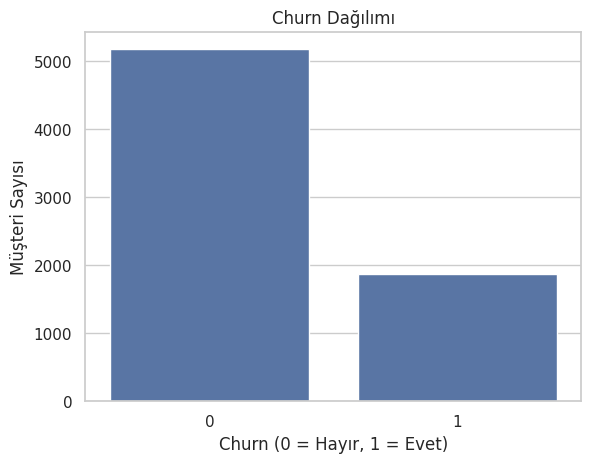

In [ ]:
sns.countplot(data=df, x='Churn')
plt.title("Churn Dağılımı")
plt.xlabel("Churn (0 = Hayır, 1 = Evet)")
plt.ylabel("Müşteri Sayısı")
plt.show()


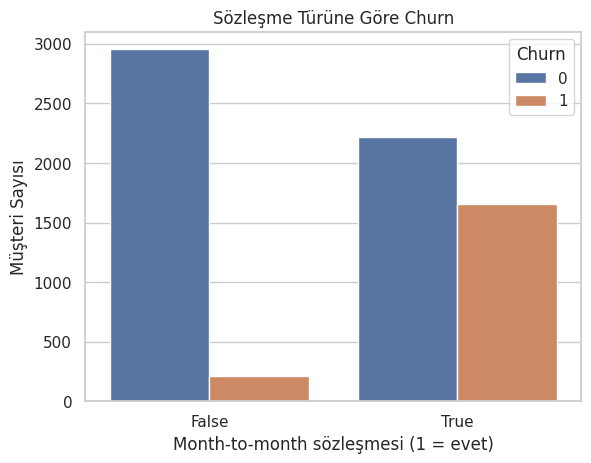

In [ ]:
sns.countplot(data=df, x='Contract_Month-to-month', hue='Churn')
plt.title("Sözleşme Türüne Göre Churn")
plt.xlabel("Month-to-month sözleşmesi (1 = evet)")
plt.ylabel("Müşteri Sayısı")
plt.show()


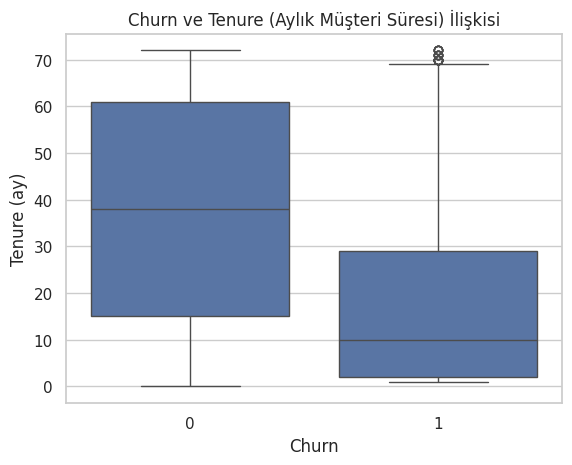

In [ ]:
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title("Churn ve Tenure (Aylık Müşteri Süresi) İlişkisi")
plt.xlabel("Churn")
plt.ylabel("Tenure (ay)")
plt.show()


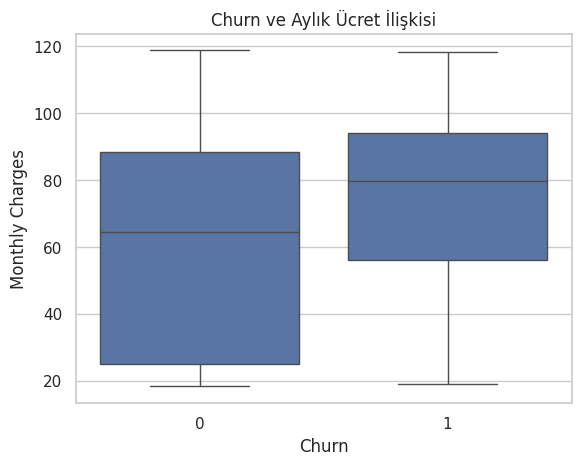

In [ ]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Churn ve Aylık Ücret İlişkisi")
plt.xlabel("Churn")
plt.ylabel("Monthly Charges")
plt.show()


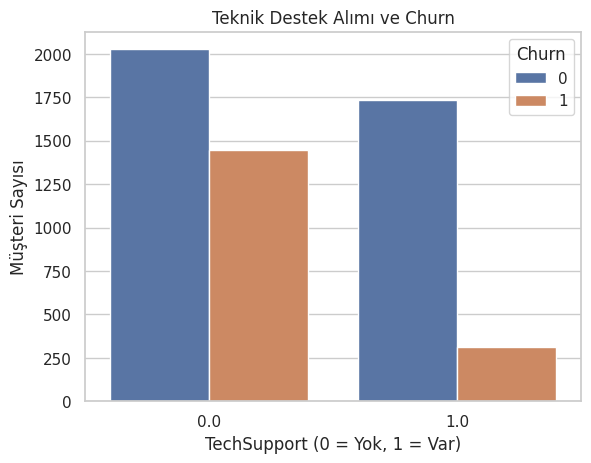

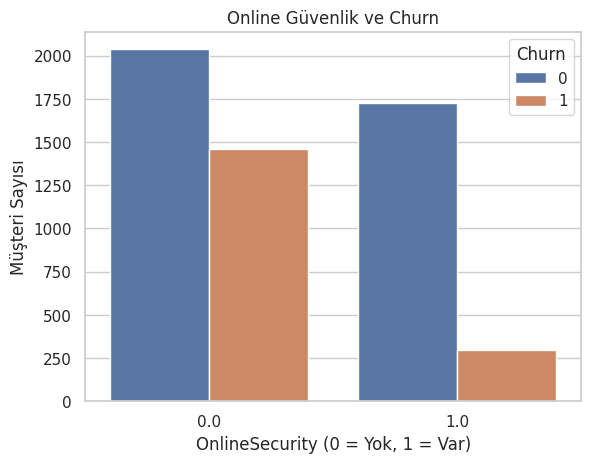

In [ ]:
sns.countplot(x='TechSupport', hue='Churn', data=df)
plt.title("Teknik Destek Alımı ve Churn")
plt.xlabel("TechSupport (0 = Yok, 1 = Var)")
plt.ylabel("Müşteri Sayısı")
plt.show()

sns.countplot(x='OnlineSecurity', hue='Churn', data=df)
plt.title("Online Güvenlik ve Churn")
plt.xlabel("OnlineSecurity (0 = Yok, 1 = Var)")
plt.ylabel("Müşteri Sayısı")
plt.show()


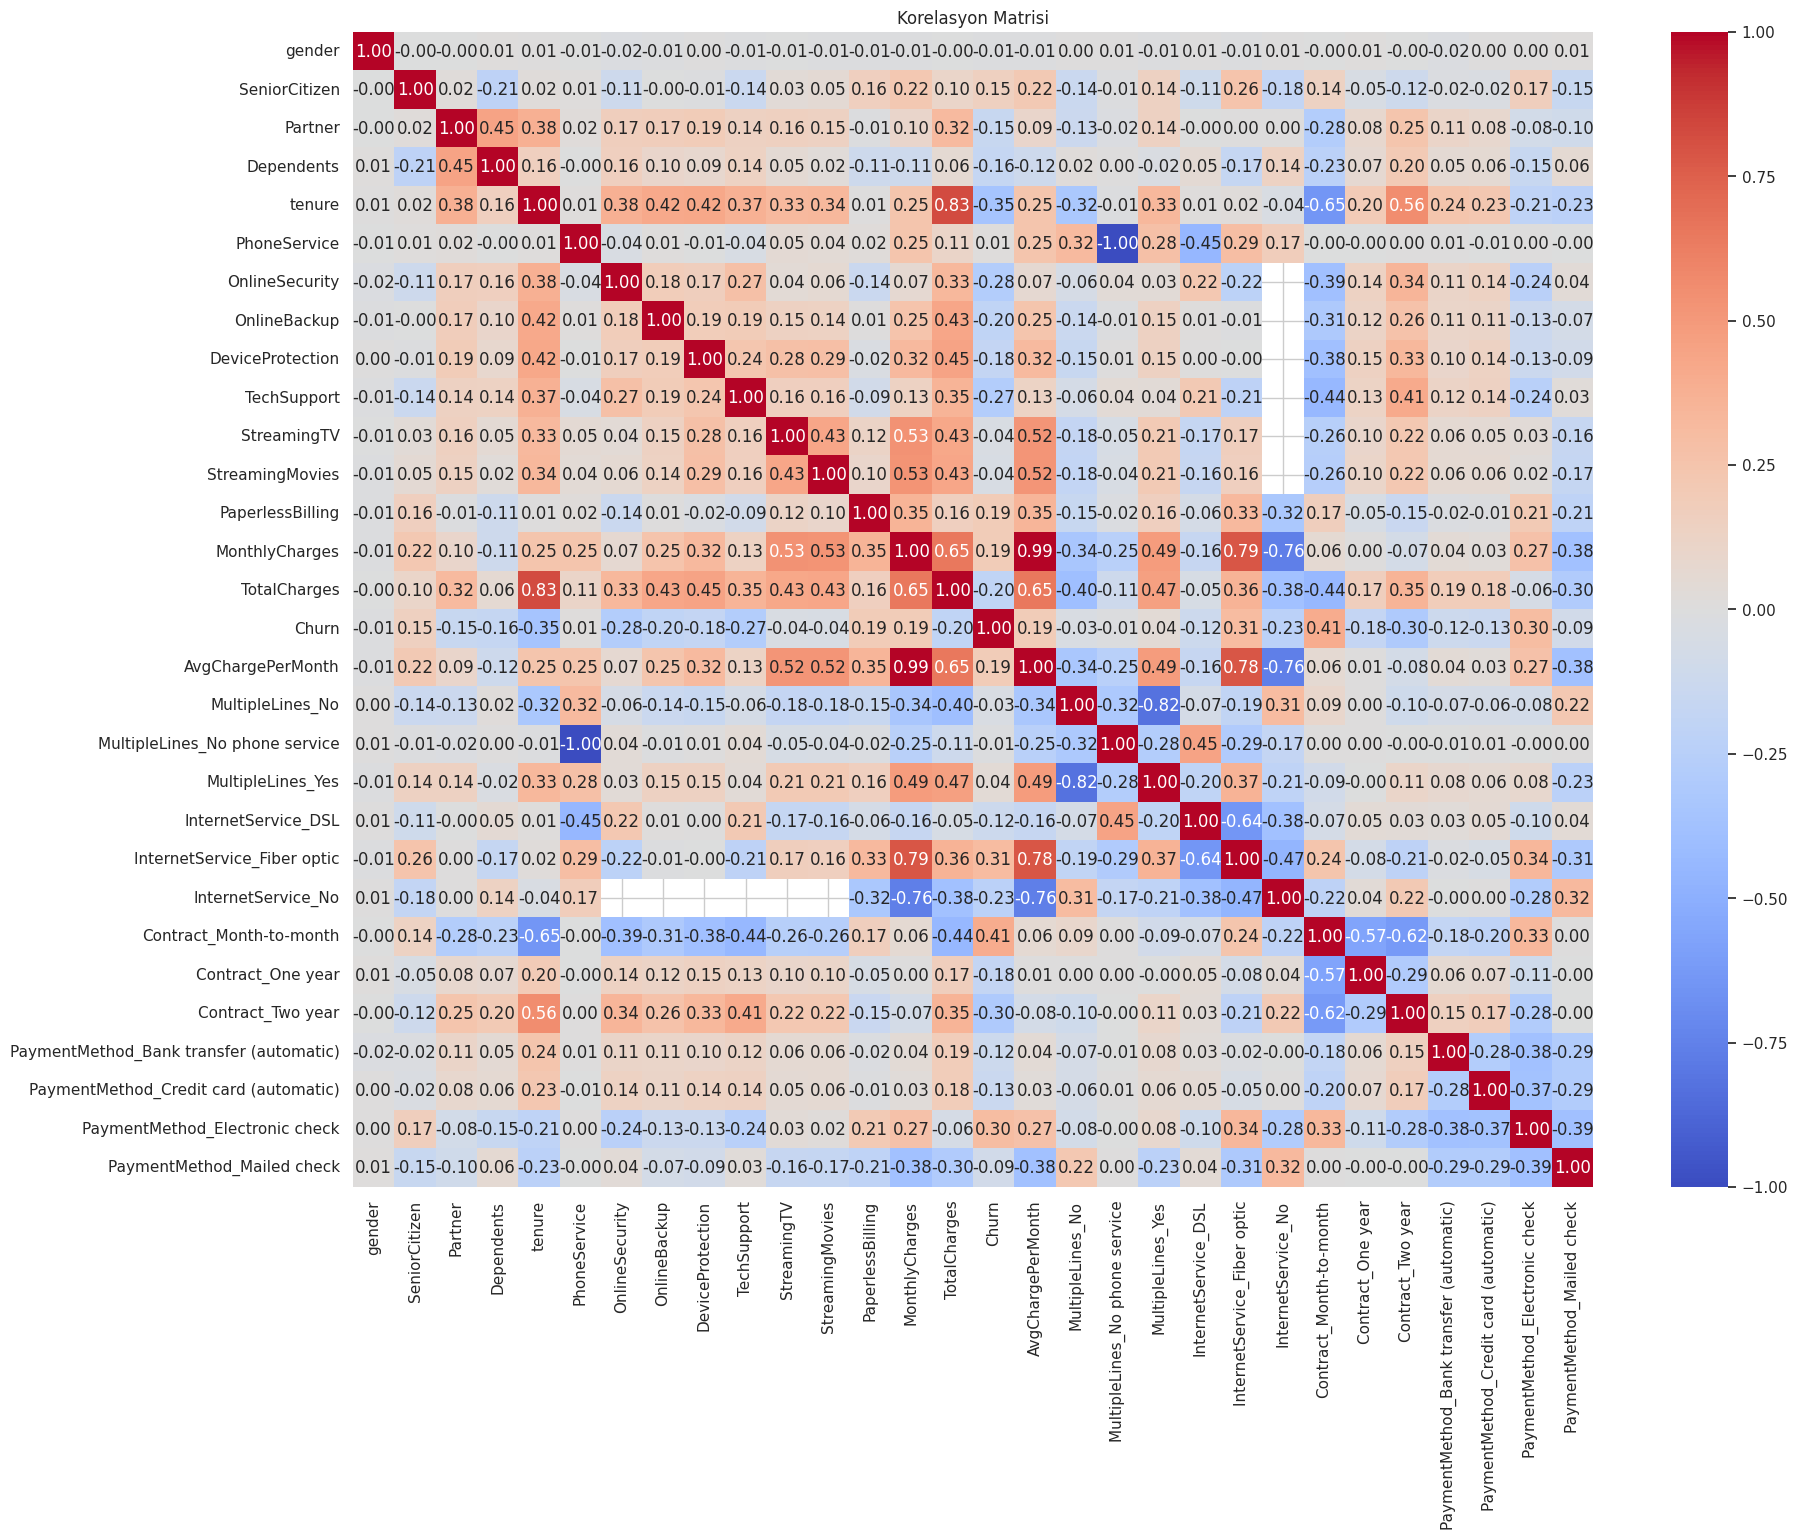

In [ ]:
plt.figure(figsize=(20, 15))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Korelasyon Matrisi")
plt.show()


6. Gün

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/cleaned_telco.csv")


Mounted at /content/drive


In [ ]:
X = df.drop(columns=['Churn', 'customerID'])
y = df['Churn']

X = X.copy()
X = X.astype({col: 'object' for col in X.select_dtypes(include='bool').columns})

num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

X[num_cols] = num_imputer.fit_transform(X[num_cols])
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])
object_cols = X.select_dtypes(include='object').columns

for col in object_cols:
    X[col] = X[col].astype('category').cat.codes

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

results = []

for name, model in models.items():
    if name == "Logistic Regression":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba)
    })

In [ ]:
model_eval_df = pd.DataFrame(results)
model_eval_df.sort_values(by='ROC AUC', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.807665,0.661442,0.564171,0.608947,0.841905
1,Random Forest,0.785664,0.620805,0.494652,0.550595,0.827726
2,XGBoost,0.781405,0.607143,0.500000,0.548387,0.822550


7. Gün

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

rfc = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=rfc, param_distributions=param_grid,
                                   n_iter=20, cv=3, verbose=1, scoring='roc_auc', random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

best_rf = random_search.best_estimator_
print("En iyi parametreler:", random_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
33 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
33 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_

En iyi parametreler: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10}


In [ ]:
from sklearn.metrics import roc_auc_score

train_pred = best_rf.predict(X_train)
test_pred = best_rf.predict(X_test)

train_auc = roc_auc_score(y_train, best_rf.predict_proba(X_train)[:, 1])
test_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])

print("Eğitim ROC AUC:", train_auc)
print("Test ROC AUC:", test_auc)


Eğitim ROC AUC: 0.9313287183419645
Test ROC AUC: 0.839696194683407


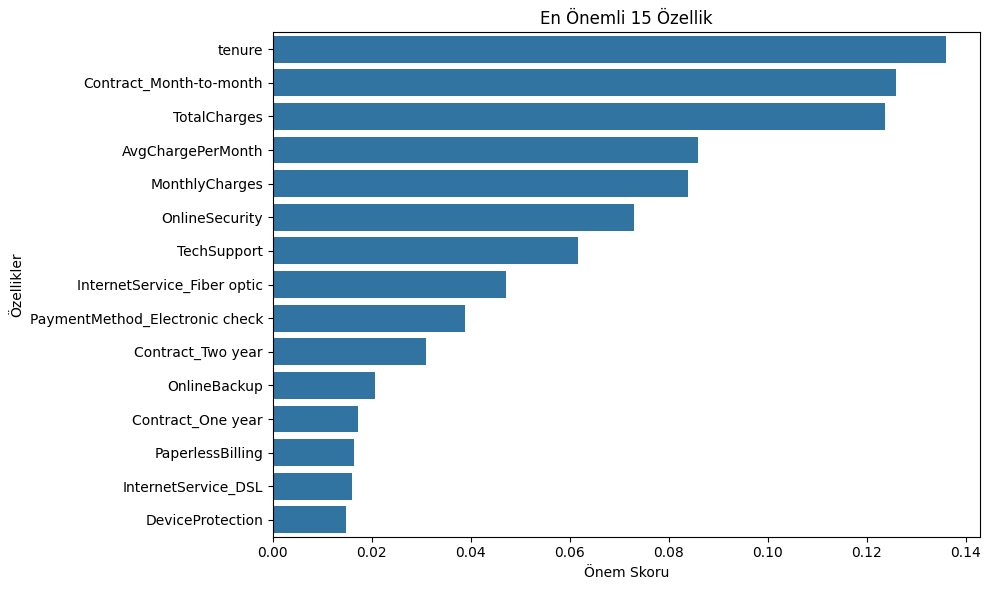

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.Series(best_rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances.values[:15], y=importances.index[:15])
plt.title("En Önemli 15 Özellik")
plt.xlabel("Önem Skoru")
plt.ylabel("Özellikler")
plt.tight_layout()
plt.show()


8. Gün

In [ ]:
import joblib

joblib.dump(best_rf, 'random_forest_best_model.pkl')
print("Model başarıyla kaydedildi.")


Model başarıyla kaydedildi.


9. Gün

In [ ]:
segment_features = [
    'SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'AvgChargePerMonth'
]
X_seg = df[segment_features].copy()


In [ ]:
X_seg.isnull().sum()
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_seg = pd.DataFrame(imputer.fit_transform(X_seg), columns=segment_features)

,0
SeniorCitizen,0
tenure,0
MonthlyCharges,0
TotalCharges,0
OnlineSecurity,0
OnlineBackup,0
DeviceProtection,0
TechSupport,0
StreamingTV,0
StreamingMovies,0


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_seg)


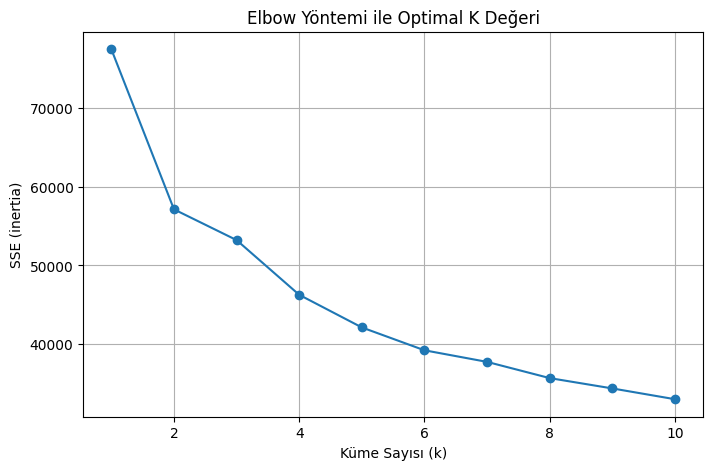

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Küme Sayısı (k)')
plt.ylabel('SSE (inertia)')
plt.title('Elbow Yöntemi ile Optimal K Değeri')
plt.grid(True)
plt.savefig('k_value.png')
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
segments = kmeans.fit_predict(X_scaled)

df['Segment'] = segments
df.to_csv("segmented_df.csv", index=False)


10. Gün

In [ ]:
segment_summary = df.groupby('Segment').agg({
    'tenure': 'mean',
    'MonthlyCharges': 'mean',
    'TotalCharges': 'mean',
    'Churn': 'mean',  # Bu churn oranı olur (0–1 arası)
    'SeniorCitizen': 'mean'
}).round(2)

segment_summary.rename(columns={
    'tenure': 'AvgTenure',
    'MonthlyCharges': 'AvgMonthlyCharges',
    'TotalCharges': 'AvgTotalCharges',
    'Churn': 'ChurnRate',
    'SeniorCitizen': 'SeniorRate'
}, inplace=True)

segment_summary

,AvgTenure,AvgMonthlyCharges,AvgTotalCharges,ChurnRate,SeniorRate
Segment,,,,,
0,35.97,66.04,2385.43,0.16,0.09
1,54.88,94.76,5196.06,0.19,0.22
2,28.83,24.04,695.98,0.12,0.04
3,13.64,72.97,1020.13,0.52,0.26


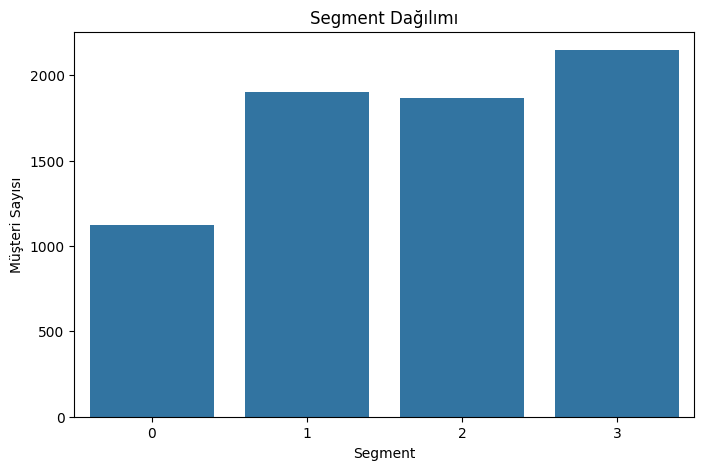

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Segment')
plt.title('Segment Dağılımı')
plt.xlabel('Segment')
plt.ylabel('Müşteri Sayısı')
plt.show()

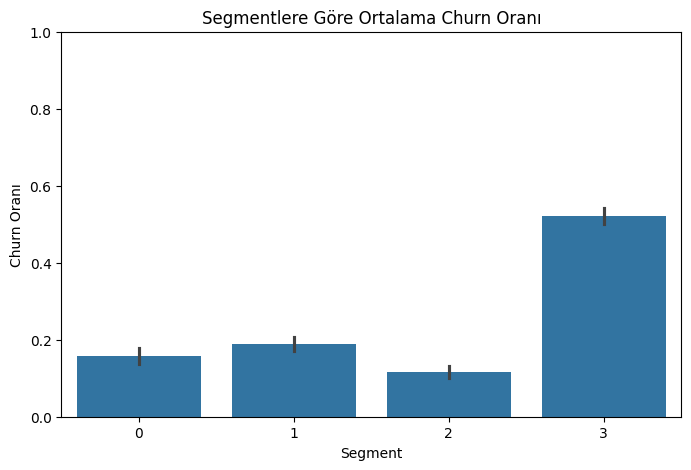

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='Segment', y='Churn')
plt.title('Segmentlere Göre Ortalama Churn Oranı')
plt.ylabel('Churn Oranı')
plt.xlabel('Segment')
plt.ylim(0, 1)
plt.show()

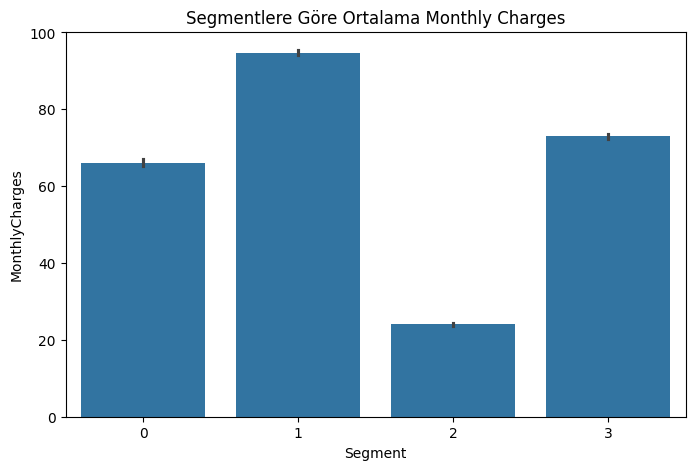

In [ ]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='Segment', y='MonthlyCharges')
plt.title('Segmentlere Göre Ortalama Monthly Charges')
plt.ylabel('MonthlyCharges')
plt.xlabel('Segment')
plt.show()

11. Gün

In [ ]:
churn_by_segment = df.groupby('Segment')['Churn'].mean().reset_index()
churn_by_segment.columns = ['Segment', 'ChurnRate']
churn_by_segment.sort_values(by='ChurnRate', ascending=False)


NameError: name 'df' is not defined

/tmp/ipython-input-6-1720609893.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=churn_by_segment, x='Segment', y='ChurnRate', palette='magma')


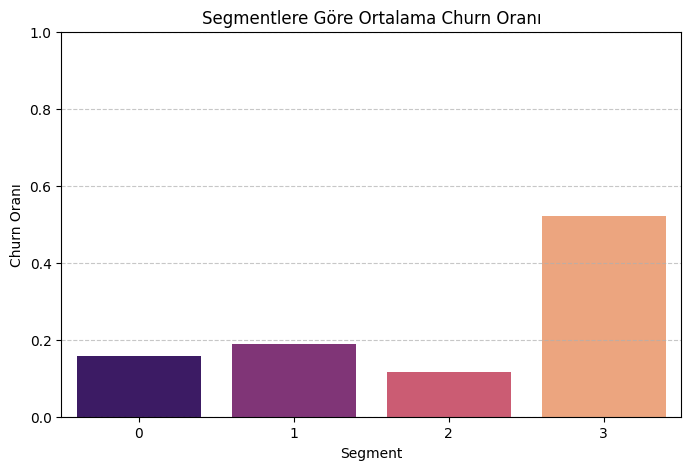

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(data=churn_by_segment, x='Segment', y='ChurnRate', palette='magma')
plt.title('Segmentlere Göre Ortalama Churn Oranı')
plt.xlabel('Segment')
plt.ylabel('Churn Oranı')
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


12. Gün

In [ ]:
import streamlit as st
from colabcode import ColabCode
ColabCode(port=8501)

# Sayfa Ayarı
st.set_page_config(page_title="Müşteri Terk Analizi Dashboard", layout="wide")

# Başlık
st.title("📊 Müşteri Terk Analizi Dashboard")
st.write("Bu dashboard, müşteri terk tahmini ve segment analizi yapmanızı sağlar.")

# Sidebar Menü
menu = st.sidebar.radio("Menü", ["Churn Tahmini", "Segment Analizi"])

if menu == "Churn Tahmini":
    st.subheader("🔍 Churn Tahmini")
    customer_id = st.text_input("Müşteri ID giriniz:")
    if st.button("Tahmin Et"):
        st.write("📌 Burada churn tahmini sonucu görünecek (model eklenecek).")
        st.progress(0.75)  # Örnek progress bar (%75 churn ihtimali)
        st.metric(label="Churn Olasılığı", value="75%", delta="+15% Risk")

elif menu == "Segment Analizi":
    st.subheader("📊 Segment Analizi")
    segment = st.selectbox("Segment Seçiniz:", ["Segment 0", "Segment 1", "Segment 2", "Segment 3"])
    st.write(f"Seçilen Segment: {segment}")
    st.write("📌 Burada segment istatistikleri ve görseller yer alacak.")
    st.bar_chart({"Churn Oranı": [0.52, 0.18, 0.15, 0.11]})


ERROR:pyngrok.process.ngrok:t=2025-07-17T12:56:59+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-07-17T12:56:59+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"


PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

In [ ]:
elif menu == "🔍 Churn Tahmini":
    st.subheader("🔍 Müşteri Bazlı Churn Tahmini")
    customer_id = st.selectbox("Müşteri Seç:", options=df[ID_COL].unique())
    if st.button("Tahmin Et"):
        row = df[df[ID_COL] == customer_id].iloc[0]
        X_input = prepare_features_for_model(row, feature_cols)
        if scaler is not None:
            X_input = scaler.transform(X_input)
        if model is not None and hasattr(model, "predict_proba"):
            prob = model.predict_proba(X_input)[0, 1]
            st.metric("Churn Olasılığı", f"{prob:.1%}")

Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: streamlit_app.py


In [ ]:
with st.form("add_customer_form"):
        col1, col2 = st.columns(2)
        with col1:
            gender = st.selectbox("Cinsiyet", ["Erkek", "Kadın"])
            age = st.number_input("Yaş", min_value=18, max_value=100, value=30)
            tenure = st.number_input("Müşteri Süresi (yıl)", min_value=0, max_value=10, value=1)
            balance = st.number_input("Bakiye", min_value=0.0, value=5000.0)
        with col2:
            products_number = st.selectbox("Ürün Sayısı", [1, 2, 3, 4])
            has_cr_card = st.selectbox("Kredi Kartı Var mı?", ["Evet", "Hayır"])
            is_active_member = st.selectbox("Aktif Müşteri mi?", ["Evet", "Hayır"])
            estimated_salary = st.number_input("Tahmini Maaş", min_value=0.0, value=3000.0)

        submitted = st.form_submit_button("Kaydet")

        if submitted:
            st.success("✅ Yeni müşteri başarıyla eklendi.")